# Efficient coding and gain control



In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
from tqdm import tqdm

In [49]:
from matplotlib import pyplot as plt

In [2]:
from neuron import h
from neuron.units import ms, mV, µm, cm, s

h.load_file("stdrun.hoc")
h.cvode_active(1)

1.0

In [15]:
class COBA:
    def __init__(self, **kwargs):
        self._setup_morphology()
        self._setup_biophysics(**kwargs)
        
        self._spike_detector = h.NetCon(self.spikeout, None)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)


    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.all = self.soma.wholetree()
        self.soma.L = self.soma.diam = 5.6418958 * µm # this way the surface area is about 100µm^2
        self.area = self.soma.L * self.soma.diam * np.pi

    def _setup_biophysics(self, leak_g=385*1e-12):
        self.capacitance = 3.1 # pF
        self.soma.cm = self.capacitance * 1e-6 / (self.area/cm**2) # Membrane capacitance in µF / cm^2
        
        # Create spiking mechanism
        self.spikeout = h.SpikeOut(self.soma(0.5))
        self.spikeout.thresh = -49 * mV # Spike threshold
        self.spikeout.refrac = 2.5 * ms # Refractory period (millisecond)
        self.spikeout.vreset = -75 * mV # Reversal potential to clamp to during the spike
        self.spikeout.grefrac = 100 / (self.area/cm**2) # Conductance used to clamp during refractory period (S/cm2)

        # Inser leak
        self.soma.insert("pas")
        for seg in self.soma:
            seg.pas.g = leak_g / (self.area/cm**2)  # Passive conductance in S/cm2
            seg.pas.e = -75 * mV  # Leak reversal potential
            
        # Add synapses
        # self.baseline = h.ExpSyn(self.soma(0.5))
        # self.baseline.tau = 10
        # self.baseline.e = 0
        
        self.exc = h.ExpSyn(self.soma(0.5))
        self.exc.tau = 10
        self.exc.e = 0
        
        self.inh = h.ExpSyn(self.soma(0.5))
        self.inh.tau = 12
        self.inh.e = -75
        
    def __repr__(self):
        return f"Conductance-based IaF cell"

In [ ]:
# compute time-averaged inhibitory conductance as a function of the inhibitory input rate


In [84]:
def rate_simulation(cell=None, exc_rate=10, inh_rate=0, duration=1, transient=0.2, record_conductance=False):
    """
    exc_rate, inh_rate are in Hz
    
    duration and transient are in seconds
    """
    
    cell = COBA() if cell is None else cell
    
    if exc_rate > 0:
        stim_exc = h.NetStim()
        stim_exc.interval = 1/exc_rate * (s/ms)
        stim_exc.start = 0
        stim_exc.number = exc_rate * duration
        stim_exc.noise = 1
        ncstim_exc = h.NetCon(stim_exc, cell.exc)
        ncstim_exc.delay = 0
        ncstim_exc.weight[0] = 732 * 1e-6

    if inh_rate > 0:
        stim_inh = h.NetStim()
        stim_inh.interval = 1/inh_rate * (s/ms)
        stim_inh.start = 0
        stim_inh.number = inh_rate * duration
        stim_inh.noise = 1
        ncstim_inh = h.NetCon(stim_inh, cell.inh)
        ncstim_inh.delay = 0
        ncstim_inh.weight[0] = 3100 * 1e-6

    if record_conductance:
        inh_g = h.Vector().record(cell.inh._ref_g)
        t = h.Vector().record(h._ref_t)
    
    h.tstop = duration * (s/ms)
    h.v_init = -75
    h.finitialize()
    h.run()
    
    if len(cell.spike_times)==0:
        nspikes = 0
    else:
        spikes = np.array(cell.spike_times)
        nspikes =  (spikes>transient*(s/ms)).sum()
    out_rate = nspikes / (duration-transient)
    
    if record_conductance:
        return out_rate, np.array(t), np.array(inh_g)
    else:
        return out_rate

In [98]:
slope_in_F_per_cm2_per_Hz = 38.494556684277e-12

3.833019546282222e-05


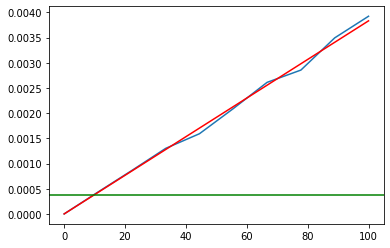

In [100]:

inh_range = np.linspace(0, 100, 10)
mean_conductance = np.zeros_like(inh_range)
for i, inh in enumerate(inh_range):
    _, t, inh_g = rate_simulation(inh_rate=inh, duration=10, record_conductance=True)
    mean_conductance[i] = np.trapz(inh_g, t) / (t.max()-t.min()) # uS

slope = mean_conductance.mean()/inh_range.mean()
print(slope)
plt.plot(inh_range, mean_conductance)   
plt.plot([0, inh_range.max()], [0, inh_range.max()*slope], color='red')
# out_rate, t, inh_g = rate_simulation(inh_rate=25, duration=10, record_conductance=True)
# mean_conductance = np.trapz(inh_g, t) / (t.max()-t.min()) # uS
# plt.plot(t, inh_g)
# plt.axhline(mean_conductance, color='red')

plt.axhline(385*1e-6, color='green')

In [128]:
n_trials = 100
exc_range = np.linspace(0, 400, 11)
inh_range = np.linspace(0, 75, 6)
ff = np.zeros((exc_range.size, inh_range.size, n_trials))
for trial in tqdm(range(n_trials)):
    for i, exc in enumerate(exc_range):
        for j, inh in enumerate(inh_range):
            ff[i,j,trial] = rate_simulation(exc_rate=exc, inh_rate=inh, transient=0.2, duration=0.4)

ff = xr.DataArray(data=ff, dims=['Exc rate (Hz)', 'Inh rate (Hz)', 'Trial'], coords=[exc_range, inh_range, range(n_trials)], name='Firing rate (Hz)')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


<AxesSubplot:xlabel='Exc rate (Hz)', ylabel='Firing rate (Hz)'>

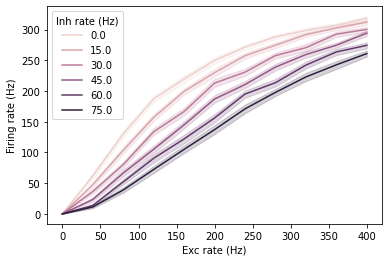

In [129]:
sns.lineplot(data=ff.to_dataframe(), x='Exc rate (Hz)', y='Firing rate (Hz)', hue='Inh rate (Hz)')

Idea: say that you have a neuron like the above, and a cost to downstream transmission. Or 6 neurons like the above, each tuned to a different stimulus property (say you're in auditory cortex and each neuron is looking at intensity of a different frequency range). Then it makes sense to set the gain such that 

In [125]:
# def input_output_simulation(exc_mean, exc_std, inh, n_trials):
#     in_freqs = np.random.normal(in_mean, in_std, size=n_trials)
#     in_freqs[in_freqs<0] = 0
#     out_frequs = np.array([rate_simulation(exc_rate=exc, inh_rate=inh, transient=0.3, duration=0.5) for exc in in_freqs])
#     return in_freqs, out_freqs

n_trials = 1000
exc_mean = 65
exc_std_range = np.linspace(5, 30, 6)
inh_range = np.linspace(0, 75, 6)
input_freqs = np.zeros((exc_std_range.size, inh_range.size, n_trials))
output_freqs = np.zeros((exc_std_range.size, inh_range.size, n_trials))

for trial in tqdm(range(n_trials)):
    for i, exc_std in enumerate(exc_std_range):
        for j, inh in enumerate(inh_range):
            exc = max(0, np.random.normal(exc_mean, exc_std))
            input_freqs[i, j, trial] = exc
            output_freqs[i, j, trial] = rate_simulation(exc_rate=exc, inh_rate=inh, transient=0.2, duration=0.4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:02<00:00,  5.49it/s]


<AxesSubplot:xlabel='Exc stdev (Hz)', ylabel='Output (Hz)'>

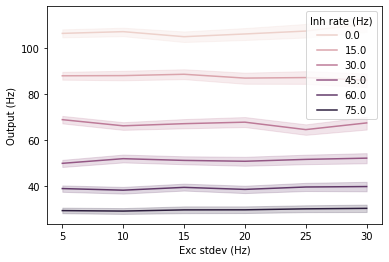

In [126]:
a = xr.Dataset(
    data_vars={
        'Input (Hz)' : (['Exc stdev (Hz)', 'Inh rate (Hz)', 'Trial'], input_freqs),
        'Output (Hz)' : (['Exc stdev (Hz)', 'Inh rate (Hz)', 'Trial'], output_freqs)},
    coords={'Exc stdev (Hz)': exc_std_range, 'Inh rate (Hz)': inh_range, 'Trial': range(n_trials)}   
)
sns.lineplot(data=a.to_dataframe(), x='Exc stdev (Hz)', y='Output (Hz)', hue='Inh rate (Hz)')

<AxesSubplot:xlabel='Input (Hz)', ylabel='Output (Hz)'>

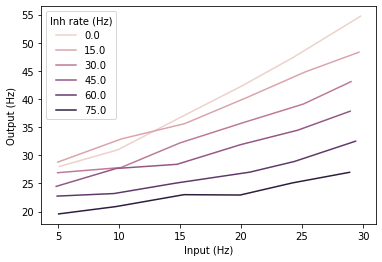

In [127]:
sns.lineplot(data=a.std(dim='Trial').to_dataframe(), x='Input (Hz)', y='Output (Hz)', hue='Inh rate (Hz)')

potentially equalized points are:



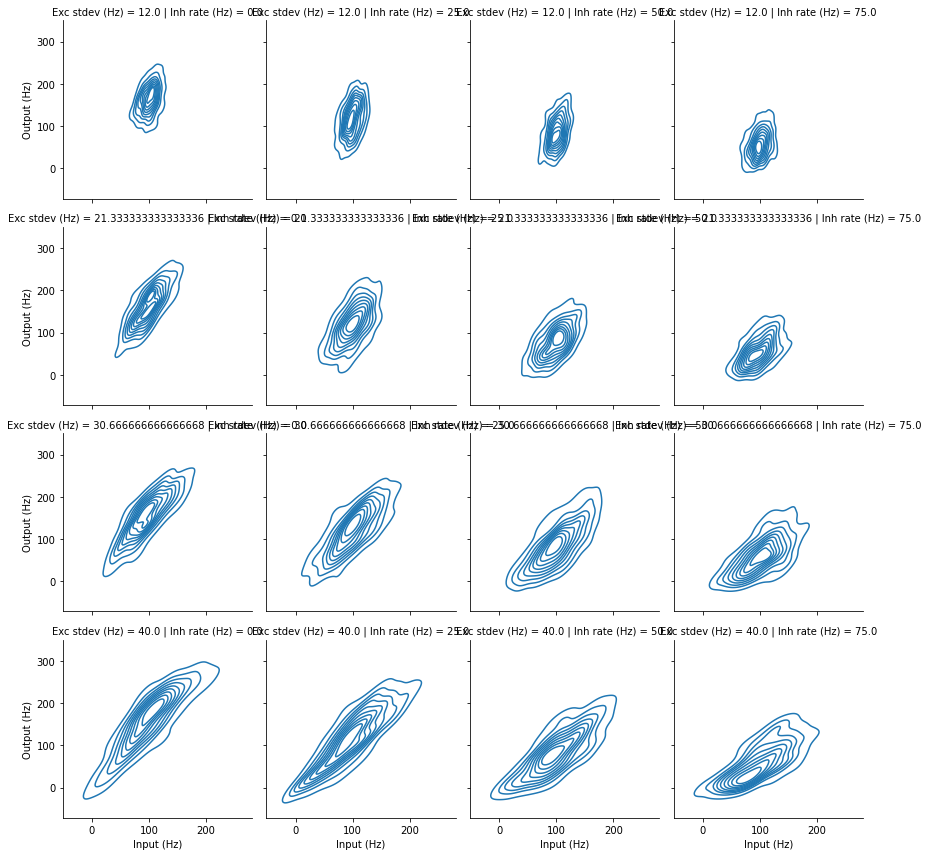

In [105]:
g = sns.FacetGrid(data=a.to_dataframe().reset_index(), row='Exc stdev (Hz)', col='Inh rate (Hz)')
#g.map(sns.kdeplot, 'Input (Hz)')
#g.map(sns.kdeplot, 'Output (Hz)', color='red')
g.map(sns.kdeplot, 'Input (Hz)', 'Output (Hz)')

In [6]:
for i in cell.spike_times:
    print(i)

2.800000000000006
11.674999999999871
16.049999999999624
20.099999999999394
23.34999999999921
26.949999999999005
30.34999999999881
34.17499999999921
38.80000000000026
45.82500000000186
56.22500000000422
61.92500000000552
71.17500000000761
74.90000000000846
79.32500000000947
85.57500000001089
89.75000000001184
95.25000000001309


In [9]:
stim = h.IClamp(my_cell.soma(1))
stim.delay = 5
stim.dur = 30
stim.amp = 0.02

soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

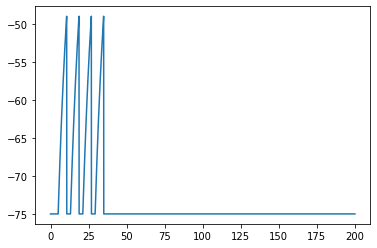

In [10]:
h.finitialize()
h.run()
plt.plot(t, soma_v)

In [12]:
len(my_cell.spike_times)

4

In [8]:
my_cell.spike_times

Vector[0]

In [9]:
for i in my_cell.spike_times:
    print(i)

10.599999999999932
18.699999999999473
26.799999999999013
34.89999999999937


In [10]:
stim_exc = h.NetStim()  # Make a new stimulator
stim_exc.interval = 10
stim_exc.start = 0
stim_exc.noise = 1
ncstim_exc = h.NetCon(stim_exc, my_cell.exc)
ncstim_exc.delay = 1 * ms
ncstim_exc.weight[0] = 732 * 1e-6


stim_inh = h.NetStim()  # Make a new stimulator
stim_inh.interval = 15
stim_inh.start = 0
stim_inh.noise = 1
ncstim_inh = h.NetCon(stim_inh, my_cell.inh)
ncstim_inh.delay = 1 * ms
ncstim_inh.weight[0] = 3100 * 1e-6

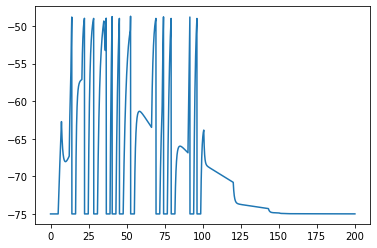

In [11]:
h.finitialize()
h.run()
plt.plot(t, soma_v)

In [12]:
for i in my_cell.spike_times:
    print(i)

13.949999999999742
22.27499999999927
28.324999999998926
36.574999999999754
40.450000000000635
45.22500000000172
52.57500000000339
69.25000000000718
74.22500000000831
79.22500000000944
91.55000000001225
96.1750000000133
